In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt

from loader import All_fundus_files
from networks import weights_init, Discriminator_128_v2, Flatten

dataroot = "data/fundus2/"
batch_size = 64
image_size = 128 #size using data aug.
num_classes = 5

ch_out = 3 
#ch_noise = 100
#ch_g = 64
ch_d = 64

num_epochs = 500
lr = 0.0002
beta1 = 0.5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
    cudnn.benchmark = True

cuda


In [3]:
# Data
transform_train = transforms.Compose([
    #transforms.RandomResizedCrop(image_size),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.ImageFolder(root=dataroot+'sorted', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

testset = torchvision.datasets.ImageFolder(root=dataroot+'val', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

classes = testset.classes
print(trainset.classes)
print(testset.class_to_idx)
print(len(trainset), len(testset))

['catergory00', 'catergory01', 'catergory02', 'catergory03', 'catergory04']
{'catergory00': 0, 'catergory01': 1, 'catergory02': 2, 'catergory03': 3, 'catergory04': 4}
3462 200


In [4]:
# Model
net = Discriminator_128_v2(ch_out, ch_d)
net.backbone[14] = nn.AdaptiveAvgPool2d((1, 1)) 
net.backbone[15] = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=ch_d * 16, out_features=num_classes, bias=True)
)
net = net.to(device)
net.apply(weights_init)
print(net)

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
'''
if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    print(best_acc,start_epoch)

'''

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [100,250], gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


Discriminator_128_v2(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): I

In [5]:
from torchsummary import summary
summary(net, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
    InstanceNorm2d-4          [-1, 128, 32, 32]               0
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
    InstanceNorm2d-7          [-1, 256, 16, 16]               0
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
   InstanceNorm2d-10            [-1, 512, 8, 8]               0
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 4, 4]               0
        LeakyReLU-14           [-1, 102

In [6]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train Loss: %.3f | Acc: %.3f%% (%d/%d)' %(train_loss / (batch_idx+1), 100.*correct/total, correct, total))
    return train_loss /(batch_idx+1), correct/total

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print('Test Loss: %.3f | Acc: %.3f%% (%d/%d)' %(test_loss /(batch_idx+1), 100.*correct/total, correct, total))
    return test_loss /(batch_idx+1), correct/total

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint/exp3'):
            os.mkdir('checkpoint/exp3')
        torch.save(state, './checkpoint/exp3/ckpt.pth')
        best_acc = acc

Train_losses = []
Test_losses = []
Train_acc = []
Test_acc = []
for epoch in range(start_epoch, start_epoch+num_epochs):
    ls, acc = train(epoch)
    Train_losses.append(ls)
    Train_acc.append(acc)
    
    ls, acc = test(epoch)
    Test_losses.append(ls)
    Test_acc.append(acc)
    
    scheduler.step()


Epoch: 0
Train Loss: 1.021 | Acc: 65.482% (2267/3462)
Test Loss: 1.803 | Acc: 34.500% (69/200)

Epoch: 1
Train Loss: 0.847 | Acc: 71.606% (2479/3462)
Test Loss: 1.748 | Acc: 35.500% (71/200)

Epoch: 2
Train Loss: 0.796 | Acc: 72.675% (2516/3462)
Test Loss: 1.741 | Acc: 37.000% (74/200)

Epoch: 3
Train Loss: 0.775 | Acc: 73.541% (2546/3462)
Test Loss: 1.666 | Acc: 36.000% (72/200)

Epoch: 4
Train Loss: 0.764 | Acc: 73.281% (2537/3462)
Test Loss: 1.558 | Acc: 38.000% (76/200)

Epoch: 5
Train Loss: 0.741 | Acc: 73.744% (2553/3462)
Test Loss: 1.623 | Acc: 36.000% (72/200)

Epoch: 6
Train Loss: 0.735 | Acc: 73.715% (2552/3462)
Test Loss: 1.716 | Acc: 37.500% (75/200)

Epoch: 7
Train Loss: 0.724 | Acc: 73.744% (2553/3462)
Test Loss: 1.603 | Acc: 38.000% (76/200)

Epoch: 8
Train Loss: 0.715 | Acc: 74.726% (2587/3462)
Test Loss: 1.593 | Acc: 44.000% (88/200)

Epoch: 9
Train Loss: 0.712 | Acc: 74.697% (2586/3462)
Test Loss: 1.510 | Acc: 46.500% (93/200)

Epoch: 10
Train Loss: 0.704 | Acc: 74.6

Test Loss: 1.346 | Acc: 52.000% (104/200)

Epoch: 85
Train Loss: 0.160 | Acc: 96.967% (3357/3462)
Test Loss: 1.358 | Acc: 51.500% (103/200)

Epoch: 86
Train Loss: 0.155 | Acc: 97.314% (3369/3462)
Test Loss: 1.431 | Acc: 54.500% (109/200)

Epoch: 87
Train Loss: 0.150 | Acc: 97.660% (3381/3462)
Test Loss: 1.202 | Acc: 53.500% (107/200)

Epoch: 88
Train Loss: 0.153 | Acc: 97.400% (3372/3462)
Test Loss: 1.109 | Acc: 56.000% (112/200)

Epoch: 89
Train Loss: 0.150 | Acc: 97.603% (3379/3462)
Test Loss: 1.222 | Acc: 57.500% (115/200)

Epoch: 90
Train Loss: 0.135 | Acc: 97.920% (3390/3462)
Test Loss: 1.139 | Acc: 56.500% (113/200)

Epoch: 91
Train Loss: 0.138 | Acc: 97.920% (3390/3462)
Test Loss: 1.354 | Acc: 48.500% (97/200)

Epoch: 92
Train Loss: 0.138 | Acc: 97.891% (3389/3462)
Test Loss: 1.453 | Acc: 54.500% (109/200)

Epoch: 93
Train Loss: 0.122 | Acc: 98.325% (3404/3462)
Test Loss: 1.380 | Acc: 54.500% (109/200)

Epoch: 94
Train Loss: 0.117 | Acc: 98.036% (3394/3462)
Test Loss: 1.597 | Ac

Test Loss: 2.210 | Acc: 52.000% (104/200)

Epoch: 168
Train Loss: 0.029 | Acc: 99.220% (3435/3462)
Test Loss: 1.843 | Acc: 54.500% (109/200)

Epoch: 169
Train Loss: 0.033 | Acc: 98.873% (3423/3462)
Test Loss: 2.302 | Acc: 52.000% (104/200)

Epoch: 170
Train Loss: 0.033 | Acc: 98.989% (3427/3462)
Test Loss: 1.715 | Acc: 52.500% (105/200)

Epoch: 171
Train Loss: 0.027 | Acc: 99.162% (3433/3462)
Test Loss: 2.014 | Acc: 50.500% (101/200)

Epoch: 172
Train Loss: 0.032 | Acc: 98.931% (3425/3462)
Test Loss: 1.812 | Acc: 54.000% (108/200)

Epoch: 173
Train Loss: 0.036 | Acc: 98.931% (3425/3462)
Test Loss: 1.714 | Acc: 49.500% (99/200)

Epoch: 174
Train Loss: 0.103 | Acc: 97.314% (3369/3462)
Test Loss: 2.045 | Acc: 51.500% (103/200)

Epoch: 175
Train Loss: 0.044 | Acc: 99.018% (3428/3462)
Test Loss: 1.374 | Acc: 56.000% (112/200)

Epoch: 176
Train Loss: 0.042 | Acc: 98.960% (3426/3462)
Test Loss: 1.700 | Acc: 55.000% (110/200)

Epoch: 177
Train Loss: 0.031 | Acc: 99.105% (3431/3462)
Test Loss: 

Test Loss: 2.096 | Acc: 53.500% (107/200)

Epoch: 251
Train Loss: 0.022 | Acc: 98.902% (3424/3462)
Test Loss: 2.271 | Acc: 51.500% (103/200)

Epoch: 252
Train Loss: 0.026 | Acc: 98.845% (3422/3462)
Test Loss: 2.077 | Acc: 54.000% (108/200)

Epoch: 253
Train Loss: 0.023 | Acc: 98.931% (3425/3462)
Test Loss: 2.295 | Acc: 52.000% (104/200)

Epoch: 254
Train Loss: 0.024 | Acc: 99.018% (3428/3462)
Test Loss: 2.251 | Acc: 51.500% (103/200)

Epoch: 255
Train Loss: 0.022 | Acc: 98.845% (3422/3462)
Test Loss: 2.268 | Acc: 54.000% (108/200)

Epoch: 256
Train Loss: 0.022 | Acc: 99.076% (3430/3462)
Test Loss: 2.137 | Acc: 52.500% (105/200)

Epoch: 257
Train Loss: 0.022 | Acc: 98.989% (3427/3462)
Test Loss: 2.299 | Acc: 52.000% (104/200)

Epoch: 258
Train Loss: 0.019 | Acc: 99.133% (3432/3462)
Test Loss: 2.191 | Acc: 53.500% (107/200)

Epoch: 259
Train Loss: 0.019 | Acc: 99.249% (3436/3462)
Test Loss: 2.048 | Acc: 54.500% (109/200)

Epoch: 260
Train Loss: 0.023 | Acc: 98.960% (3426/3462)
Test Loss:

Test Loss: 2.485 | Acc: 52.500% (105/200)

Epoch: 334
Train Loss: 0.018 | Acc: 98.873% (3423/3462)
Test Loss: 2.249 | Acc: 53.500% (107/200)

Epoch: 335
Train Loss: 0.016 | Acc: 99.133% (3432/3462)
Test Loss: 2.373 | Acc: 52.500% (105/200)

Epoch: 336
Train Loss: 0.015 | Acc: 99.162% (3433/3462)
Test Loss: 2.225 | Acc: 52.000% (104/200)

Epoch: 337
Train Loss: 0.016 | Acc: 99.018% (3428/3462)
Test Loss: 2.286 | Acc: 51.500% (103/200)

Epoch: 338
Train Loss: 0.017 | Acc: 98.931% (3425/3462)
Test Loss: 2.300 | Acc: 53.500% (107/200)

Epoch: 339
Train Loss: 0.014 | Acc: 99.307% (3438/3462)
Test Loss: 2.289 | Acc: 52.000% (104/200)

Epoch: 340
Train Loss: 0.014 | Acc: 99.105% (3431/3462)
Test Loss: 2.492 | Acc: 52.000% (104/200)

Epoch: 341
Train Loss: 0.016 | Acc: 99.076% (3430/3462)
Test Loss: 2.347 | Acc: 53.000% (106/200)

Epoch: 342
Train Loss: 0.017 | Acc: 99.076% (3430/3462)
Test Loss: 2.393 | Acc: 51.500% (103/200)

Epoch: 343
Train Loss: 0.018 | Acc: 98.931% (3425/3462)
Test Loss:

Test Loss: 2.508 | Acc: 52.000% (104/200)

Epoch: 417
Train Loss: 0.015 | Acc: 99.047% (3429/3462)
Test Loss: 2.496 | Acc: 52.000% (104/200)

Epoch: 418
Train Loss: 0.013 | Acc: 99.278% (3437/3462)
Test Loss: 2.480 | Acc: 52.000% (104/200)

Epoch: 419
Train Loss: 0.016 | Acc: 99.133% (3432/3462)
Test Loss: 2.517 | Acc: 52.000% (104/200)

Epoch: 420
Train Loss: 0.014 | Acc: 99.105% (3431/3462)
Test Loss: 2.553 | Acc: 52.000% (104/200)

Epoch: 421
Train Loss: 0.014 | Acc: 98.960% (3426/3462)
Test Loss: 2.481 | Acc: 51.500% (103/200)

Epoch: 422
Train Loss: 0.013 | Acc: 99.162% (3433/3462)
Test Loss: 2.459 | Acc: 51.500% (103/200)

Epoch: 423
Train Loss: 0.015 | Acc: 99.076% (3430/3462)
Test Loss: 2.472 | Acc: 51.500% (103/200)

Epoch: 424
Train Loss: 0.014 | Acc: 99.191% (3434/3462)
Test Loss: 2.483 | Acc: 51.500% (103/200)

Epoch: 425
Train Loss: 0.013 | Acc: 99.249% (3436/3462)
Test Loss: 2.474 | Acc: 51.500% (103/200)

Epoch: 426
Train Loss: 0.014 | Acc: 99.047% (3429/3462)
Test Loss:

Test Loss: 2.530 | Acc: 51.500% (103/200)


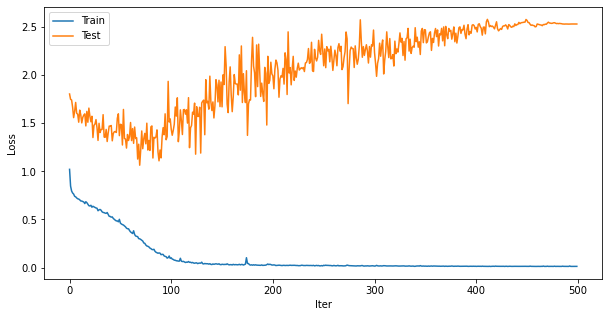

In [7]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(Train_losses,label="Train")
plt.plot(Test_losses,label="Test")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

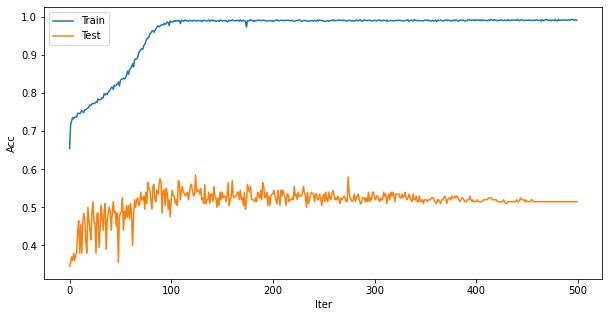

In [8]:
# check acc
plt.figure(figsize=(10,5))
plt.plot(Train_acc,label="Train")
plt.plot(Test_acc,label="Test")
plt.xlabel("Iter")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [9]:
def test_only():
    net.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))
    return (100 * correct / total)

acc = test_only() 

Accuracy of the network on the 10000 test images: 51.500000 %


In [10]:
def test_each_class():
    net.eval()
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.2f} %".format(classname,
        accuracy))

test_each_class()

Accuracy for class catergory00 is: 97.50 %
Accuracy for class catergory01 is: 55.00 %
Accuracy for class catergory02 is: 82.50 %
Accuracy for class catergory03 is: 17.50 %
Accuracy for class catergory04 is: 5.00 %


In [ ]:
# save
state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
#torch.save(state, './checkpoint/ckpt_fin.pth')

In [ ]:
# load
resume = 'ckpt'
checkpoint = torch.load('./checkpoint/'+resume+'.pth')
#net.load_state_dict(checkpoint['net'])

In [ ]:
acc = test_only() 
test_each_class()